In [2]:
!pip install numpy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 830.8 kB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.3 which is incompatible.


In [4]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23s_msai/week0_10_embeddings_and_seq2seq/names -O names

--2024-11-11 03:26:49--  https://raw.githubusercontent.com/girafe-ai/ml-course/23s_msai/week0_10_embeddings_and_seq2seq/names
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 55868 (55K) [text/plain]
Сохранение в: «names»

names               100%[===================>]  54,56K  --.-KB/s    за 0,05s   

2024-11-11 03:26:50 (1,09 MB/s) - «names» сохранён [55868/55868]



In [5]:
import os

start_token = '<'
end_token = '>'
pad_token = '_'

In [6]:
with open('names') as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + line + end_token for line in names]

In [7]:
print('n samples = ',len(names))
for x in names[::1000]:
    print(x)

n samples =  7944
<Abagael>
<Claresta>
<Glory>
<Liliane>
<Prissie>
<Geeta>
<Giovanne>
<Piggy>


In [8]:
MAX_LENGTH = max(map(len, names))
print('max length - ', MAX_LENGTH)

max length -  17


(array([1.900e+01, 2.720e+02, 0.000e+00, 9.270e+02, 0.000e+00, 1.877e+03,
        0.000e+00, 2.049e+03, 0.000e+00, 1.447e+03, 0.000e+00, 8.460e+02,
        0.000e+00, 3.510e+02, 0.000e+00, 1.160e+02, 0.000e+00, 2.400e+01,
        0.000e+00, 1.000e+01, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00]),
 array([ 4.  ,  4.52,  5.04,  5.56,  6.08,  6.6 ,  7.12,  7.64,  8.16,
         8.68,  9.2 ,  9.72, 10.24, 10.76, 11.28, 11.8 , 12.32, 12.84,
        13.36, 13.88, 14.4 , 14.92, 15.44, 15.96, 16.48, 17.  ]),
 <BarContainer object of 25 artists>)

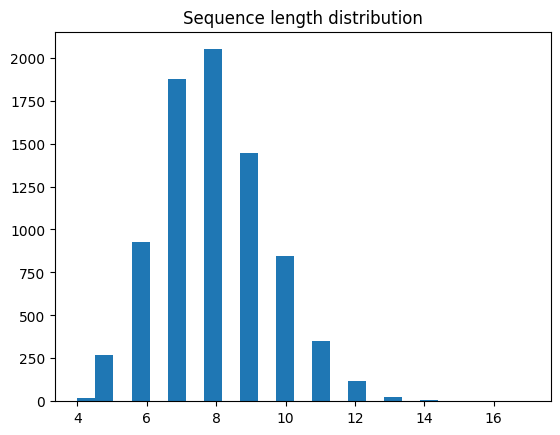

In [9]:
plt.title('Sequence length distribution')
plt.hist(list(map(len,names)), bins=25)

# Text processing
Collect a vocabulary of all unique tokens. We can then encode inputs as a sequence of character ids

In [10]:
tokens = set()
for name in names:
    tokens.update(set(name))

tokens.update({pad_token})
tokens = list(tokens)

num_tokens = len(tokens)
print('num_tokens = ', num_tokens)

assert(
    50 < num_tokens < 60
)

num_tokens =  58


In [11]:
pad_token in tokens

True

# Convert characters to integer

In [12]:
id_to_token = list(tokens)
token_to_id = {token: idx for idx, token in enumerate(id_to_token)}

In [14]:
assert len(tokens) == len(token_to_id), 'dictionaries must have same size'

for i in range(num_tokens):
    assert(
        token_to_id[tokens[i]] == i
    ), "token identifier must be it's position in tokens list"
print('Seems alright!')

Seems alright!


In [15]:
def to_matrix(
        names_batch,
        max_len=None,
        pad=token_to_id[pad_token],
        dtype='int32',
        batch_first=False,
):
    max_len = max_len or max(map(len, names_batch))
    names_ix = np.zeros([len(names_batch), max_len], dtype) + pad

    for i in range(len(names_batch)):
        line_x = [token_to_id[c] for c in names_batch[i]][:max_len]
        names_ix[i,:len(line_x)] = line_x

    if not batch_first: # convert [batch,time] into [time,batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [16]:
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]).T)


<Abagael>
<Glory>
<Prissie>
<Giovanne>
[[21  3 43 57 25 57 30 33 23 56]
 [21 52 33 14 39 44 23 56 56 56]
 [21 54 39 27 37 37 27 30 23 56]
 [21 52 27 14 18 57 26 26 30 23]]


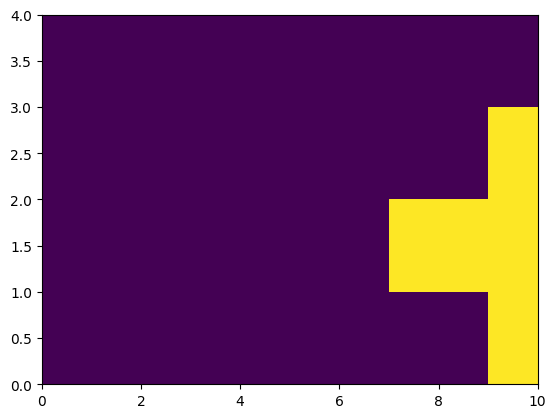

In [17]:
plt.pcolormesh(to_matrix(names[::2000]).T == token_to_id[pad_token])

# Recurent neural network

In [18]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [19]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size = 16, rnn_num_units = 64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        x_emb = self.embedding(x)

        x_and_h = torch.cat([x_emb,h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)

        h_next = torch.tanh(h_next)

        assert h_next.size() == h_prev.size()

        logits = self.rnn_to_logits(h_next)

        return h_next,logits
    def initial_state( self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [20]:
char_rnn = CharRNNCell()

# RNN loop

In [21]:
def rnn_loop(char_rnn, batch_ix):
    max_length, batch_size = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    all_logits = []

    for x_t in batch_ix:
        hid_state, logits_next = char_rnn(
            x_t, hid_state
        )
        all_logits.append(logits_next)

    return torch.stack(all_logits,dim=1)

In [22]:
batch_ix = to_matrix(names[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

all_logits = rnn_loop(char_rnn,batch_ix)

In [23]:
all_logits.shape

torch.Size([5, 9, 58])

# Lakelyhood and gradients
We can train our neural network to minimize crossentropy (maximize log-likelihood) with the actual next tokens.

In [25]:
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_id[pad_token])
actual_next_tokens = batch_ix[1:,:].T

pred_logits = all_logits[:,:-1,:]
pred_logits_flattened = pred_logits.reshape(
    (pred_logits.shape[0] * pred_logits.shape[1], -1)
)
actual_next_tokens_flattened = actual_next_tokens.reshape(-1)

In [26]:
print(pred_logits_flattened.shape)
print(actual_next_tokens_flattened.shape)

torch.Size([40, 58])
torch.Size([40])


In [27]:
loss = loss_func(pred_logits_flattened,actual_next_tokens_flattened)

In [28]:
loss.backward()

In [29]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() !=0,(
        'Loss is not differentiable w.r.t. a weight with shape $s. Check forward method.' 
        % (w.size(),)
    )

# The training loop

In [30]:
from IPython.display import clear_output
from random import sample

char_rnn =CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

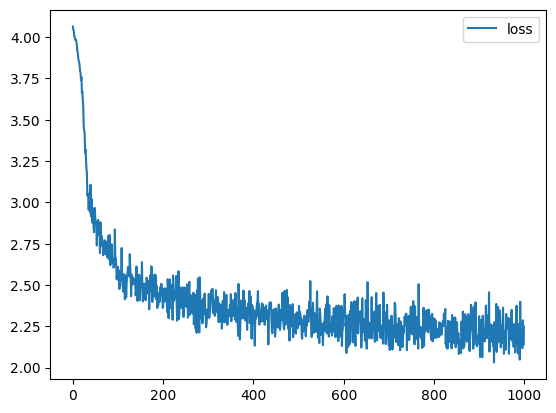

In [31]:
MAX_LENGTH = 16

for i in range(1000):
    opt.zero_grad()
    batch_ix = to_matrix(sample(names,32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype= torch.int64)

    all_logits = rnn_loop(char_rnn, batch_ix)

    actual_next_tokens = batch_ix[1:,:].T

    pred_logits = all_logits[:,:-1,:]
    pred_logits_flattened = pred_logits.reshape(
        (pred_logits.shape[0] * pred_logits.shape[1], -1)
    )
    actual_next_tokens_flattened = actual_next_tokens.reshape(-1)
    loss = loss_func(pred_logits_flattened, actual_next_tokens_flattened)

    loss.backward()
    opt.step()

    history.append(loss.item())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge"



# RNN:sampling

In [32]:
def generate_sample(
        char_rnn, seed_phrase = '<', max_length= MAX_LENGTH, temperature=1,pretty_print=True
):
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    for i in range(len(seed_phrase) - 1):
        hid_state, _ =char_rnn(x_sequence[:,i],hid_state)

    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits_next = char_rnn(x_sequence[:,-1], hid_state)
        p_next = F.softmax(logits_next / temperature, dim=1).data.numpy()[0]

        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    output = ' '.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])
    if pretty_print:
        output = output.split('>')[0][1:]

    return output

In [33]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=2.5))

 W M i n m y o a 
 E w k ' S i n e y e 
 I f b d C l 
 H y m e 
 R o l i a b 
 Z a h k e r a b d x i 
 D u d b p r 
 R z e b k h h y 
 M i n H E s a R 
 C o S u c T 


In [36]:
for _ in range(50):
    print(generate_sample(char_rnn, seed_phrase='AAASJAA'))

 A A S J A A l l e 
 A A S J A A n a n n e a 
 A A S J A A n n r y 
 A A S J A A 
 A A S J A A n e 
 A A S J A A l e 
 A A S J A A l i n e 
 A A S J A A t i 
 A A S J A A l a 
 A A S J A A n t i n 
 A A S J A A s v e 
 A A S J A A m u e n n 
 A A S J A A n d N e l 
 A A S J A A t u r 
 A A S J A A r e g 
 A A S J A A d p 
 A A S J A A f n e 
 A A S J A A b e r i n 
 A A S J A A 
 A A S J A A l l a 
 A A S J A A n 
 A A S J A A i l a n 
 A A S J A A l e n 
 A A S J A A l m e 
 A A S J A A d a h 
 A A S J A A n 
 A A S J A A l 
 A A S J A A n 
 A A S J A A l u d n T e h 
 A A S J A A t s 
 A A S J A A l l e t t 
 A A S J A A 
 A A S J A A t t 
 A A S J A A d a 
 A A S J A A r 
 A A S J A A d r l e 
 A A S J A A g h e y 
 A A S J A A h y 
 A A S J A A t t e 
 A A S J A A n n 
 A A S J A A 
 A A S J A A 
 A A S J A A 
 A A S J A A u 
 A A S J A A y 
 A A S J A A r 
 A A S J A A s t e s t 
 A A S J A A l e 
 A A S J A A s t e p c e 
 A A S J A A l i e 
